In [1]:
import os
import sys
import time
import h5py

import numpy as np
from glob import glob

from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [3]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [4]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]    

In [5]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

cmap_pct, A = gu.precip_cmap()

In [6]:
# data size info
x_mrms = 256; y_mrms = 576 # 0.1 deg MRMS size
x_gfs = 105; y_gfs = 242 # 0.25 deg GFS size

Nx_pred = 2
Ny_pred = 5
Ny_gap = 12
size_pred = 128

lon_128 = np.empty((Nx_pred*Ny_pred, size_pred, size_pred,)); lon_128[...] = np.nan
lat_128 = np.empty((Nx_pred*Ny_pred, size_pred, size_pred,)); lat_128[...] = np.nan

count = 0
for px in range(Nx_pred):
    for py in range(Ny_pred):
        ix0 = size_pred*px
        ix1 = ix0+size_pred
        
        if py < (Ny_pred-1):
            iy0 = (size_pred-Ny_gap)*py
            iy1 = iy0 + size_pred
        else:
            iy1 = y_mrms
            iy0 = y_mrms - size_pred

        lon_128[count, ...] = lon_01[ix0:ix1, iy0:iy1]
        lat_128[count, ...] = lat_01[ix0:ix1, iy0:iy1]
        count += 1

In [11]:
year = 2023
base = datetime(year, 1, 1)
date_list = [base + timedelta(days=d) for d in range(365)]

In [9]:
name = '/glade/campaign/cisl/aiml/ksha/LDM_results/LDM_day{:03d}_ini{:02d}_lead{:02d}.npy'
ini = 0
lead = 24

day = 116
loc_patch = 3

temp_data = np.load(name.format(day, ini, lead), allow_pickle=True)[()]
MRMS_pred = np.exp(temp_data['MRMS_pred']) - 1
MRMS_true = np.exp(temp_data['MRMS_true']) - 1
APCP_true = np.exp(temp_data['APCP_true']) - 1

MRMS_pred[MRMS_pred<0] = 0

MAE_pred = np.mean(np.abs(MRMS_pred[:, loc_patch, ...] - MRMS_true[loc_patch, ...][None, ...]), axis=(1, 2))
print(MAE_pred)
MAE_apcp = np.mean(np.abs(APCP_true[loc_patch, ...]-MRMS_true[loc_patch, ...]))
print(MAE_apcp)


# # ================================================================================= #
# for day in range(300):
#     try:
#         temp_data = np.load(name.format(day, ini, lead), allow_pickle=True)[()]
#         MRMS_pred = np.exp(temp_data['MRMS_pred']) - 1
#         MRMS_true = np.exp(temp_data['MRMS_true']) - 1
#         APCP_true = np.exp(temp_data['APCP_true']) - 1
#         MRMS_pred[MRMS_pred<0] = 0
        
#         for i in range(9):
#             fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
#             ax1.pcolormesh(APCP_true[i, ...], vmin=0, vmax=15, cmap=cmap_pct)
#             ax2.pcolormesh(MRMS_true[i, ...], vmin=0, vmax=15, cmap=cmap_pct)
#             ax3.pcolormesh(MRMS_pred[1, i, ...], vmin=0, vmax=15, cmap=cmap_pct)
#             ax3.set_title('{} {}'.format(day, i), fontsize=14)
#     except:
#         print('xxx')
    


[2.59010085 2.57672867 2.76228533 2.58496327 2.6551772  2.57615059
 2.62441849 2.80356264 2.63010468 2.6175973 ]
3.3041064424810616


In [12]:
date_list[day]

datetime.datetime(2023, 4, 27, 0, 0)

Text(0.5, 0.05, '3-hr accumulated precip [mm]')

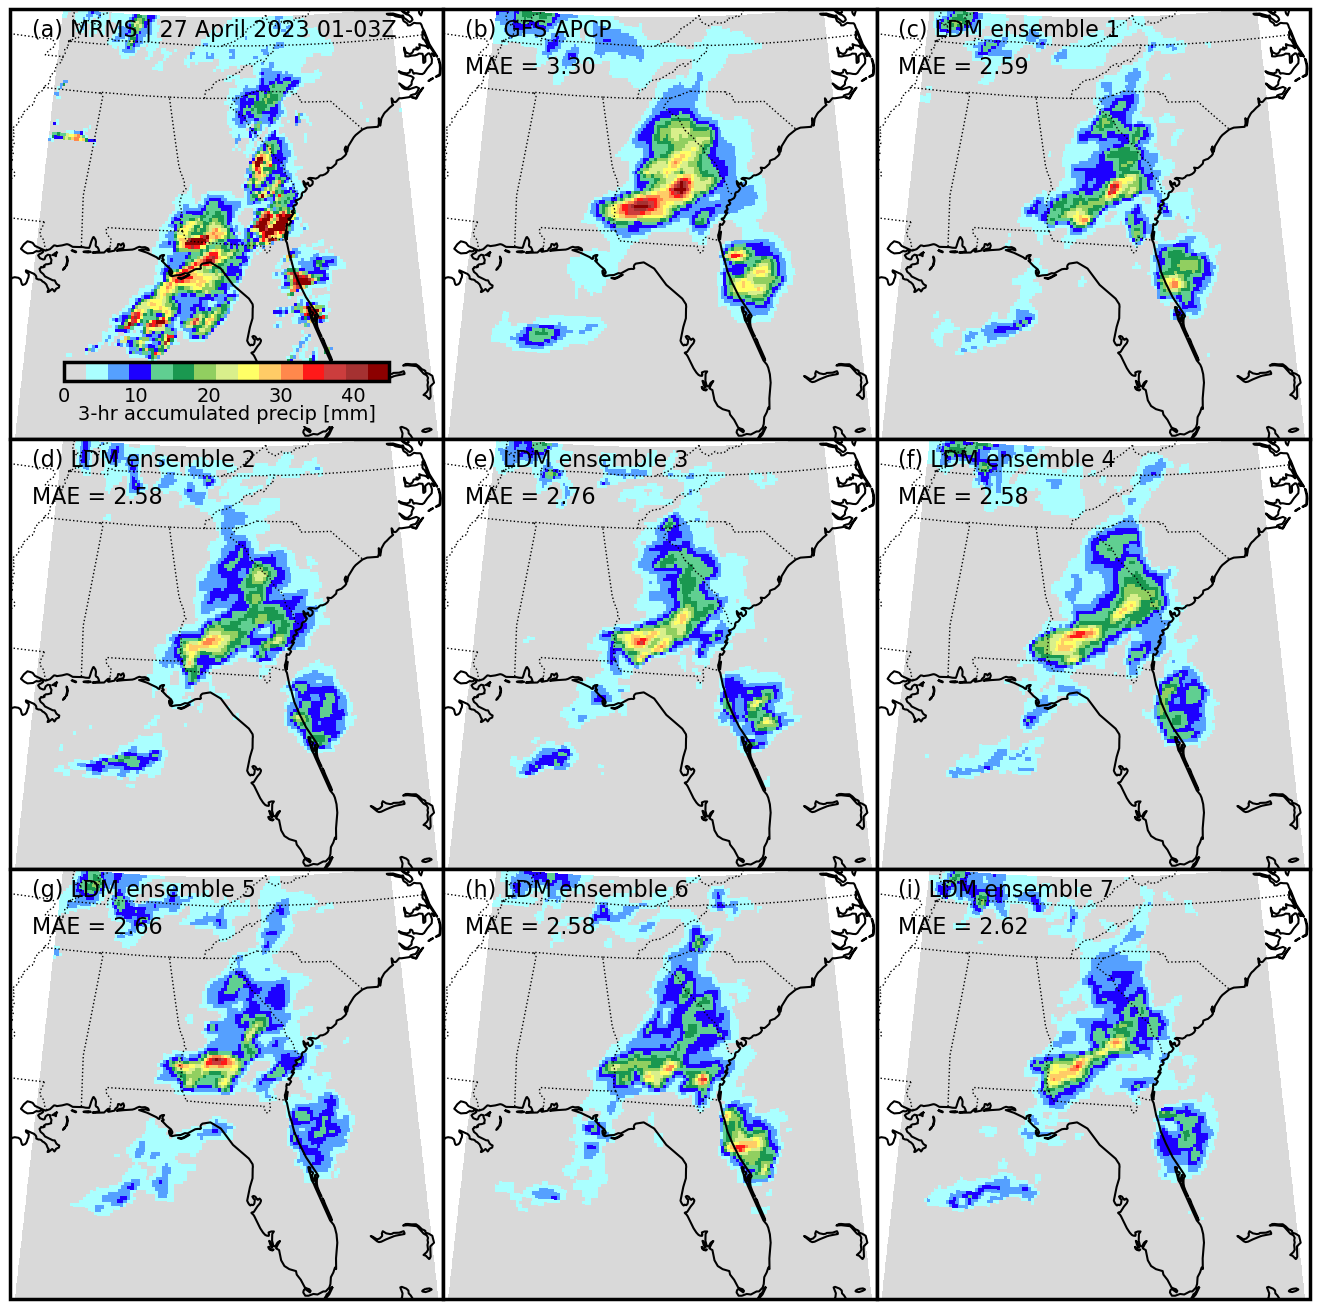

In [13]:
lon_patch = lon_128[loc_patch, ...]
lat_patch = lat_128[loc_patch, ...]

edge = [np.min(lon_patch)-0.2, np.max(lon_patch)+0.2, np.min(lat_patch), np.max(lat_patch)]

fig = plt.figure(figsize=(13, 12.9)) #, dpi=dpi_
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

proj_ = ccrs.NorthPolarStereo(central_longitude=0.5*(edge[0] + edge[1]))

ax0 = plt.subplot(gs[0, 0], projection=proj_)
ax1 = plt.subplot(gs[0, 1], projection=proj_)
ax2 = plt.subplot(gs[0, 2], projection=proj_)
ax3 = plt.subplot(gs[1, 0], projection=proj_)
ax4 = plt.subplot(gs[1, 1], projection=proj_)
ax5 = plt.subplot(gs[1, 2], projection=proj_)
ax6 = plt.subplot(gs[2, 0], projection=proj_)
ax7 = plt.subplot(gs[2, 1], projection=proj_)
ax8 = plt.subplot(gs[2, 2], projection=proj_)

titles = ['(a) MRMS | 27 April 2023 22-24Z', '(b) GFS APCP', '(c) LDM ensemble 1', 
          '(d) LDM ensemble 2', '(e) LDM ensemble 3', '(f) LDM ensemble 4', '(g) LDM ensemble 5', 
          '(h) LDM ensemble 6', '(i) LDM ensemble 7', '(j) LDM ensemble 8']

for i, ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]):
    ax.set_extent(edge, ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.0, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    ax.text(0.05, 0.98, titles[i], ha='left', va='top', fontsize=16, transform=ax.transAxes)
    if i == 1:
        ax.text(0.05, 0.85, 'MAE = {:0.2f}'.format(MAE_apcp), fontsize=16, transform=ax.transAxes)
    if i >= 2:
        ax.text(0.05, 0.85, 'MAE = {:0.2f}'.format(MAE_pred[i-2]), fontsize=16, transform=ax.transAxes)
        
plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

CS1 = ax0.pcolormesh(lon_patch, lat_patch, MRMS_true[loc_patch, ...], vmin=0, vmax=45, cmap=cmap_pct, transform=ccrs.PlateCarree())

ax1.pcolormesh(lon_patch, lat_patch, APCP_true[loc_patch, ...], vmin=0, vmax=45, cmap=cmap_pct, transform=ccrs.PlateCarree())

for i, ax in enumerate([ax2, ax3, ax4, ax5, ax6, ax7, ax8]):
    ax.pcolormesh(lon_patch, lat_patch, MRMS_pred[i, loc_patch, ...], vmin=0, vmax=45, cmap=cmap_pct, transform=ccrs.PlateCarree())
    

ax_base = fig.add_axes([0.5*(1/3-1/4), 2/3+0.01, 1/4, 0.05])
ax_base.set_facecolor(A[0, ...])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS1, orientation='horizontal', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(0.5, 0.05, '3-hr accumulated precip [mm]', ha='center', va='bottom', fontsize=14, transform=ax_base.transAxes)

# ax1.set_title('(a) GFS APCP | 01-03Z 1 January 2021', fontsize=14)
# ax2.set_title('(b) MRMS QPE | 01-03Z 1 January 2021', fontsize=14)